# Finetuning Torchvision Models
Two types of transfer learning on the pretrained [torchvision models](https://pytorch.org/docs/stable/torchvision/models.html)

- finetuning
  >start with a pretrained model

  >update `all` of the model’s parameters for our new task, in essence retraining the whole model. 

- feature extraction
  >start with a pretrained model
  
   >`only` update the final layer weights from which we derive predictions. More about transfer learning see [here](https://cs231n.github.io/transfer-learning/) and [here](https://ruder.io/transfer-learning/).

In general both transfer learning methods follow the same few steps:

-  `Initialize` the pretrained model
-  `Reshape the final layer(s)` to have the same number of outputs as the number of classes in the new dataset
-  `Define for the optimization` algorithm which parameters we want to update during training
-  `Run` the training step




In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import time
import os
import copy

### Dataset
We will use the **[hymenoptera_data](https://download.pytorch.org/tutorial/hymenoptera_data.zip)** dataset

This dataset contains two classes, **bees** and **ants**,
and is structured such that we can use the [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.ImageFolder) dataset, 
rather than writing our own custom dataset. 

### Helper Functions

In [3]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [4]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

## Initialize and Reshape the Networks
**[Resnet](https://arxiv.org/abs/1512.03385)**
> There are several variants of different sizes, including Resnet18, Resnet34, Resnet50, Resnet101, and Resnet152

> Here we use `Resnet18`, as our dataset is small and only has two classes. 

> model.fc = nn.Linear(512, num_classes)

**[Alexnet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)**
> The first very successful CNN on the ImageNet dataset

> output comes from the 6th layer of the classifier

> model.classifier[6] = nn.Linear(4096, num_classes)

**[VGG](https://arxiv.org/pdf/1409.1556.pdf)**
> Torchvision offers eight versions of VGG with various lengths and some that have batch normalizations layers

> Here we use VGG-11 with batch normalization

> model.classifier[6] = nn.Linear(4096, num_classes)

**[Squeezenet](https://arxiv.org/abs/1602.07360)**
> uses a different output structure than any of the other models shown here

> Torchvision has two versions of Squeezenet, we use version 1.0

> The output comes from a 1x1 convolutional layer which is the 1st layer of the classifier

> model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))

**[Densenet](https://arxiv.org/abs/1608.06993)**
> Torchvision has four variants of Densenet

> We use Densenet-121

> model.classifier = nn.Linear(1024, num_classes)

In [5]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 224

    if model_name == "resnet":
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)

    elif model_name == "alexnet":
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)

    elif model_name == "vgg":
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)

    elif model_name == "squeezenet":
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes

    elif model_name == "densenet":
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes) 

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

In [7]:
data_dir = "data/hymenoptera_data"
model_name = "resnet"  # [resnet, alexnet, vgg, squeezenet, densenet]
num_classes = 2
batch_size = 8
feature_extract = True
input_size = 224

model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

Load Data
---------
Initialize the data transforms, image datasets, and the dataloaders

Notice, the models were pretrained with the hard-coded normalization values, as described [here](https://pytorch.org/docs/master/torchvision/models.html).




In [35]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Finished initializing Datasets and Dataloaders")

Finished initializing Datasets and Dataloaders


Optimizer
--------------------

Now that the model structure is correct, the final step for finetuning
and feature extracting is to create an optimizer that only updates the
desired parameters. Recall that after loading the pretrained model, but
before reshaping, if ``feature_extract=True`` we manually set all of the
parameter’s ``.requires_grad`` attributes to False. Then the
reinitialized layer’s parameters have ``.requires_grad=True`` by
default. So now we know that *all parameters that have
.requires_grad=True should be optimized.* Next, we make a list of such
parameters and input this list to the SGD algorithm constructor.

To verify this, check out the printed parameters to learn. When
finetuning, this list should be long and include all of the model
parameters. However, when feature extracting this list should be short
and only include the weights and biases of the reshaped layers.




In [36]:
model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 fc.weight
	 fc.bias


Training and Validation Step
--------------------------------

Finally, the last step is to setup the loss for the model, then run the
training and validation function for the set number of epochs. Notice,
depending on the number of epochs this step may take a while on a CPU.
Also, the default learning rate is not optimal for all of the models, so
to achieve maximum accuracy it would be necessary to tune for each model
separately.




In [40]:
criterion = nn.CrossEntropyLoss()
num_epochs = 10
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/9
----------
train Loss: 0.4080 Acc: 0.8279
val Loss: 0.2694 Acc: 0.9085

Epoch 1/9
----------
train Loss: 0.3358 Acc: 0.8402
val Loss: 0.2087 Acc: 0.9412

Epoch 2/9
----------
train Loss: 0.2825 Acc: 0.8934
val Loss: 0.2222 Acc: 0.9216

Epoch 3/9
----------
train Loss: 0.3964 Acc: 0.8115
val Loss: 0.2164 Acc: 0.9150

Epoch 4/9
----------
train Loss: 0.2958 Acc: 0.8852
val Loss: 0.2355 Acc: 0.9216

Epoch 5/9
----------
train Loss: 0.2567 Acc: 0.9057
val Loss: 0.2208 Acc: 0.9346

Epoch 6/9
----------
train Loss: 0.3100 Acc: 0.8811
val Loss: 0.1941 Acc: 0.9346

Epoch 7/9
----------
train Loss: 0.2527 Acc: 0.8852
val Loss: 0.2042 Acc: 0.9412

Epoch 8/9
----------
train Loss: 0.2733 Acc: 0.8852
val Loss: 0.2943 Acc: 0.8954

Epoch 9/9
----------
train Loss: 0.3333 Acc: 0.8607
val Loss: 0.2045 Acc: 0.9412

Training complete in 2m 39s
Best val Acc: 0.941176


Comparison with Model Trained from Scratch
------------------------------------------

Just for fun, lets see how the model learns if we do not use transfer
learning. The performance of finetuning vs. feature extracting depends
largely on the dataset but in general both transfer learning methods
produce favorable results in terms of training time and overall accuracy
versus a model trained from scratch.

Epoch 0/9
----------
train Loss: 0.7830 Acc: 0.5123
val Loss: 0.8654 Acc: 0.6209

Epoch 1/9
----------
train Loss: 0.7989 Acc: 0.4713
val Loss: 0.6723 Acc: 0.6471

Epoch 2/9
----------
train Loss: 0.6835 Acc: 0.6393
val Loss: 0.7482 Acc: 0.5686

Epoch 3/9
----------
train Loss: 0.6674 Acc: 0.6148
val Loss: 0.5967 Acc: 0.6275

Epoch 4/9
----------
train Loss: 0.6531 Acc: 0.6352
val Loss: 0.5571 Acc: 0.7255

Epoch 5/9
----------
train Loss: 0.6251 Acc: 0.6639
val Loss: 0.7095 Acc: 0.6078

Epoch 6/9
----------
train Loss: 0.5993 Acc: 0.6680
val Loss: 0.5590 Acc: 0.7190

Epoch 7/9
----------
train Loss: 0.5899 Acc: 0.6475
val Loss: 0.6389 Acc: 0.6405

Epoch 8/9
----------
train Loss: 0.6680 Acc: 0.6803
val Loss: 0.6150 Acc: 0.7451

Epoch 9/9
----------
train Loss: 0.5927 Acc: 0.7008
val Loss: 0.6840 Acc: 0.6797

Training complete in 2m 41s
Best val Acc: 0.745098


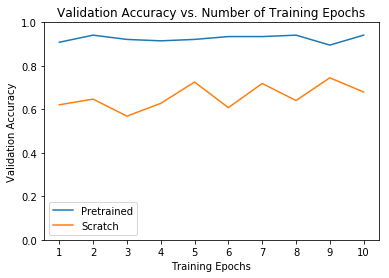

In [41]:
# Initialize the non-pretrained version of the model used for this run
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs)

ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]
shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()